In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SpectralCoord
barycorrlist=[]
sc_nm_list = []
sc_kms_list = []
mjd=[]
ltt_barylist=[]
bjdlist = []
for i in range(1, 22):
    hdul=fits.open(f'VIS_{i:02}.fits')
    mjd.append(hdul[0].header['MJD-OBS'])
for i in range(1, 22):
    file = f'VIS_{i:02}.fits'
    hdul = fits.open(file)
    flux_data = hdul[0].data
    header = hdul[0].header
    start_wavelength_nm = header['CRVAL1']
    wavelength_step_nm = header['CDELT1']
    pixel_axis = np.arange(len(flux_data))
    wavelength_nm = start_wavelength_nm + (pixel_axis * wavelength_step_nm)
    sc = SpectralCoord(wavelength_nm, unit='nm')
    sc_kms = sc.to(u.km / u.s, doppler_convention='optical', doppler_rest=656.276 * u.nm)
    sc_nm_list.append(sc)
    sc_kms_list.append(sc_kms)
    
for i in range (1,22):
    from astropy import time, coordinates as coord, units as u
    VIS = coord.SkyCoord("21:21:18.6", "-09:43:29.0", unit=(u.hourangle, u.deg), frame='icrs')
    paranal = coord.EarthLocation.of_site('paranal')
    times = time.Time([mjd[i-1]+(300 / 86400.0)], format='mjd', scale='utc', location=paranal)
    barycorr = VIS.radial_velocity_correction(obstime=times)
    barycorrlist.append(barycorr)
    ltt_bary = times.light_travel_time(VIS)
    ltt_barylist.append(ltt_bary)
    time_barycentre = times.tdb + ltt_bary.value.item()
    bjdlist.append(time_barycentre)

    
bary_nmlist = []
for i in range (1,22):
    bary_nm = sc_nm_list[i-1].with_radial_velocity_shift(barycorrlist[i-1])
    bary_nmlist.append(bary_nm)

print(bary_nmlist)

[<SpectralCoord 
   (observer to target:
      radial_velocity=[-10.19499201] km / s
      redshift=[-3.40062546e-05])
  [ 533.64185222,  533.66185154,  533.68185086, ..., 1019.92531498,
   1019.9453143 , 1019.96531362] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-10.21473654] km / s
      redshift=[-3.40721131e-05])
  [ 533.64181708,  533.66181639,  533.68181571, ..., 1019.92524781,
   1019.94524713, 1019.96524644] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-10.23501766] km / s
      redshift=[-3.41397613e-05])
  [ 533.64178097,  533.66178029,  533.68177961, ..., 1019.92517881,
   1019.94517813, 1019.96517744] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-10.25579867] km / s
      redshift=[-3.42090769e-05])
  [ 533.64174398,  533.6617433 ,  533.68174262, ..., 1019.92510811,
   1019.94510743, 1019.96510674] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-10.27706638] km / s
      redshift=[-3.

In [17]:
def orbitalphasefunc():
    T0_val = 59385.541376
    P = 0.0953979016
    T0 = time.Time(T0_val, format='mjd', scale='tdb')
    orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]
    return orbitalphase

In [18]:
final_params=[ 3.76788011e+01 , 4.53658700e+01 ,-4.17207264e-01,  5.02974774e+01,
  1.98337287e+01 , 3.33838906e+02 , 4.37246818e-01,  2.38910124e+01,
 -1.79325494e-05,  1.13647558e+00] 
gamma_wd=final_params[0]
k_wd=final_params[1]
orbitalphase=orbitalphasefunc()
restframe_nmlist=[]
for index, phase in enumerate(orbitalphase):
    bary_corrected_sc = bary_nmlist[index]
    v_obs_wd = gamma_wd - k_wd * np.sin(2 * np.pi * phase)
    v_correction = -v_obs_wd * (u.km / u.s)
    
    # Apply the shift to create the rest-frame wavelength axis
    restframe_nm = bary_corrected_sc.with_radial_velocity_shift(v_correction)
    restframe_nmlist.append(restframe_nm)    
print(restframe_nmlist)

[<SpectralCoord 
   (observer to target:
      radial_velocity=[-12.19876911] km / s
      redshift=[-4.0689886e-05])
  [ 533.63828544,  533.65828462,  533.67828381, ..., 1019.91849794,
   1019.93849713, 1019.95849632] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-3.12568984] km / s
      redshift=[-1.04261247e-05])
  [ 533.65443599,  533.67443579,  533.69443558, ..., 1019.94936577,
   1019.96936556, 1019.98936535] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-5.14873119] km / s
      redshift=[-1.71741711e-05])
  [ 533.65083483,  533.67083449,  533.69083414, ..., 1019.94248303,
   1019.96248269, 1019.98248235] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-17.74334871] km / s
      redshift=[-5.91836892e-05])
  [ 533.62841603,  533.64841485,  533.66841367, ..., 1019.899635  ,
   1019.91963382, 1019.93963264] nm>, <SpectralCoord 
   (observer to target:
      radial_velocity=[-37.80897396] km / s
      redshift=[-0.000

/tmp/ipykernel_137999/2926889284.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  orbitalphase = [float(np.mod((btime - T0).value / P, 1)) for btime in bjdlist]


The median of the 21 individual median fluxes is: 0.0000


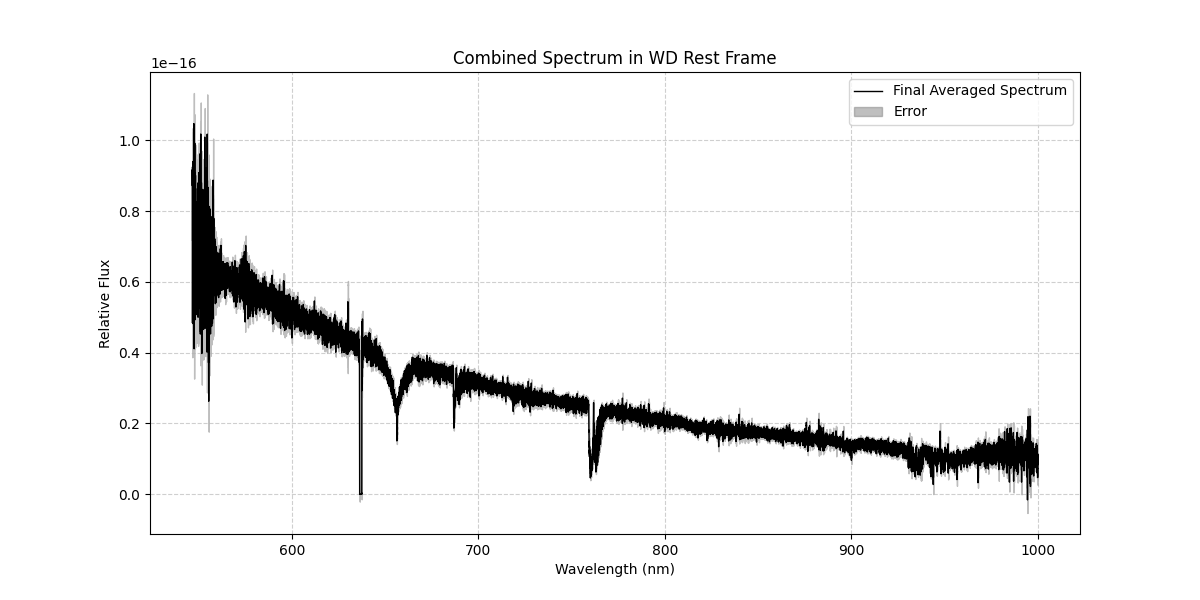

In [22]:
import scipy
import pandas as pd
from astropy.stats import sigma_clip
import numpy.ma as ma
%matplotlib widget
common_wavelength_axis_nm = np.arange(546.5, 1000.0, 0.02)
resampled_flux_list = []
file_list = [f'VIS_{i:02}.fits' for i in range(1, 22)]

n_mc = 200  # Number of Monte Carlo simulations

# These lists will store the results for each of the 21 spectra
list_of_mean_fluxes = []
list_of_flux_errors = []

for i, fitfile in enumerate(file_list):
    with fits.open(fitfile) as hdul:
        flux_data = hdul[0].data
        flux_error = hdul[1].data
    
    simulated_fluxes = np.random.normal(
        loc=flux_data, 
        scale=flux_error, 
        size=(n_mc, len(flux_data)))
    
    resampled_simulations = []
    for j in range(n_mc):
        f = scipy.interpolate.interp1d(
            restframe_nmlist[i].value, 
            simulated_fluxes[j, :],
            kind='cubic', 
            bounds_error=False, 
            fill_value=np.nan)
        resampled_simulations.append(f(common_wavelength_axis_nm))
    
    resampled_per_spectrum = np.array(resampled_simulations)
    
    mean_flux = np.nanmean(resampled_per_spectrum, axis=0)
    std_dev_flux = np.nanstd(resampled_per_spectrum, axis=0)
    
    # Append the results to our master lists
    list_of_mean_fluxes.append(mean_flux)
    list_of_flux_errors.append(std_dev_flux)


resampled_flux_array = np.array(list_of_mean_fluxes)
resampled_error_array = np.array(list_of_flux_errors) 

median_fluxes = []
normalised_flux_list = []
normalised_error_list = [] 

for i in range(len(resampled_flux_array)):
    flux_spectrum = resampled_flux_array[i]
    error_spectrum = resampled_error_array[i]
    
    median_val = np.nanmedian(flux_spectrum)
    median_fluxes.append(median_val)
    
    # Normalise flux and store the result
    normalised_flux = flux_spectrum / median_val
    normalised_flux_list.append(normalised_flux)
    
    # Propagate the error for the normalisation
    normalised_error = error_spectrum / median_val
    normalised_error_list.append(normalised_error)

normalised_flux_array = np.array(normalised_flux_list)
normalised_error_array = np.array(normalised_error_list) 
#---modification---
clipped_flux_array = sigma_clip(normalised_flux_array, sigma=3, maxiters=5, axis=0)

# Calculate the average flux using the median 
average_normalised_flux = ma.median(clipped_flux_array, axis=0).data

# Apply the exact same mask from the flux clipping to the error array.
# This ensures that if a flux value was rejected, its error is also rejected.
masked_error_array = ma.array(normalised_error_array, mask=clipped_flux_array.mask)

# Now, recalculate the error on the mean using only the un-masked values.
# This is the standard formula for combining errors: sqrt(sum of variances) / N
sum_of_variances = ma.sum(masked_error_array**2, axis=0).data
N_clipped = clipped_flux_array.count(axis=0)

error_on_average_normalised_flux = np.sqrt(sum_of_variances) / N_clipped

# Take the median of the 21 individual median fluxes
median_of_medians = np.nanmedian(median_fluxes)

# Create the final spectrum by re-scaling the average
final_average_spectrum = average_normalised_flux * median_of_medians

# Scale the propagated error by the same median factor
final_spectrum_error = error_on_average_normalised_flux * median_of_medians

print(f"The median of the 21 individual median fluxes is: {median_of_medians:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(common_wavelength_axis_nm, final_average_spectrum, label='Final Averaged Spectrum', color='black', linewidth=1)
plt.fill_between(
    common_wavelength_axis_nm,
    final_average_spectrum - final_spectrum_error,
    final_average_spectrum + final_spectrum_error,
    color='gray', alpha=0.5, label='Error'
)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative Flux')
plt.title('Combined Spectrum in WD Rest Frame')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [35]:
final_spectrum = pd.DataFrame({
    'wavelength_nm': common_wavelength_axis_nm,
    'flux': final_average_spectrum,
    'flux_error': final_spectrum_error
})

output_filename_csv = 'VIS_final_spectrum_with_errors(v3).csv'

# Save the DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
final_spectrum.to_csv(output_filename_csv, index=False, float_format='%.8e')


In [30]:
print(f"{common_wavelength_axis_nm[4]:.20e}")

5.46579999999999927240e+02


In [31]:
print(median_fluxes)

[np.float64(2.1238708823655233e-17), np.float64(2.2353434250103514e-17), np.float64(1.9481397238045793e-17), np.float64(2.1598407426529553e-17), np.float64(2.283316227043915e-17), np.float64(2.140697563326354e-17), np.float64(2.343022255090888e-17), np.float64(2.303110397480879e-17), np.float64(2.3540972220582478e-17), np.float64(2.143817615640538e-17), np.float64(2.3604659440326533e-17), np.float64(2.4280344989304306e-17), np.float64(2.2024908109846037e-17), np.float64(2.2390529853385007e-17), np.float64(2.449206217065454e-17), np.float64(2.5058690026314618e-17), np.float64(2.4749949562322e-17), np.float64(2.268705305867433e-17), np.float64(2.247906945258901e-17), np.float64(2.2825225336425488e-17), np.float64(2.3258629405880704e-17)]
